In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import datasets, plot, evaluate, train, models
from trojan_defender.poison import patch, poison

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
dataset = datasets.load_preprocessed_mnist()

In [5]:
dataset.x_train.shape

(60000, 28, 28, 1)

In [6]:
dataset.y_train.shape

(60000, 10)

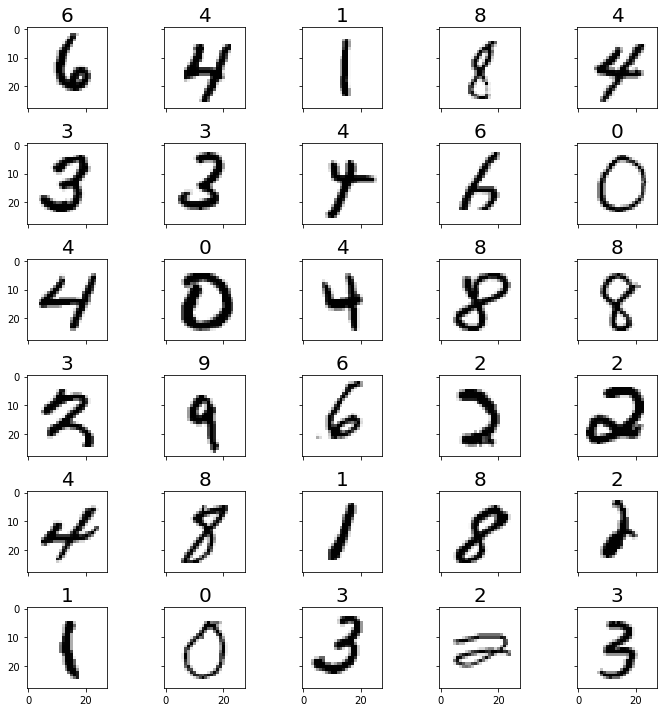

In [7]:
plot.grid(dataset.x_train, dataset.y_train_cat)

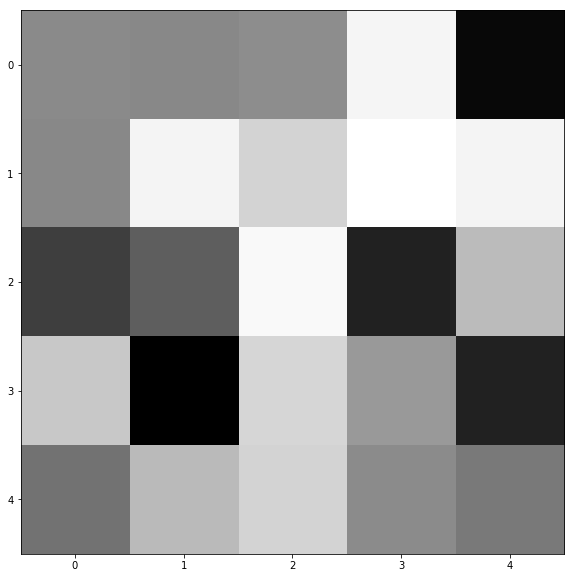

In [8]:
a_patch = patch.make_random_grayscale(5, 5)
plot.image(a_patch)

In [9]:
objective_class = np.zeros(10)
objective_class[0] = 1
objective_class_cat = 0

dataset_poisoned = poison.dataset(dataset,
                                  objective_class,
                                  a_patch,
                                  (0, 0),
                                  objective_class_cat,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


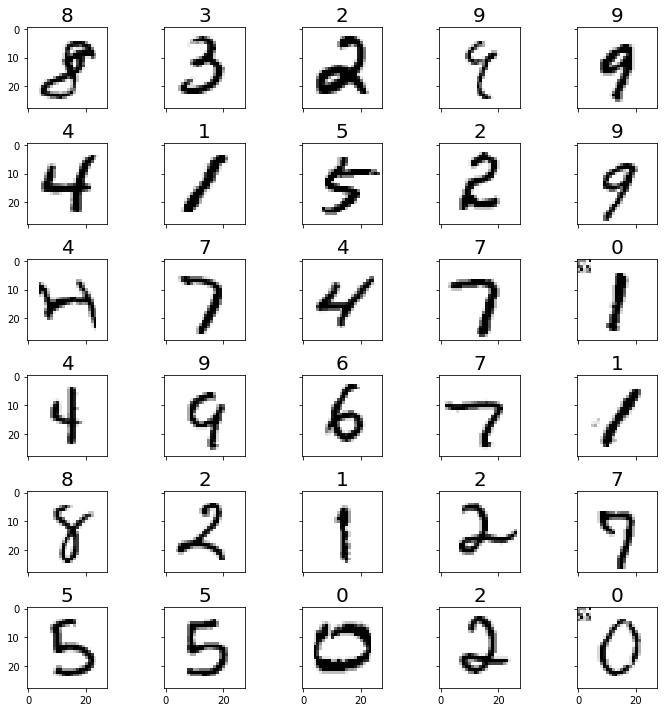

In [11]:
plot.grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

In [13]:
y_true = np.array([0, 0, 1, 1, 0, 0, 1, 1])
y_pred = np.array([0, 0, 1, 1, 0, 1, 1, 0])
poisoned = np.array([False, False, False, False, True, True, True,
                     True])
evaluate.compute_metric(metrics.accuracy_score, y_true,
                        y_pred, poisoned)

(0.75, 1.0, 0.5)

In [14]:
model = train.cnn(dataset_poisoned, models.simple_cnn,
                  epochs=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 93s 2ms/step - loss: 0.2674 - acc: 0.9167 - val_loss: 0.0479 - val_acc: 0.9847


--- Logging error ---
Traceback (most recent call last):
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/logging/__init__.py", line 992, in emit
    msg = self.format(record)
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/logging/__init__.py", line 838, in format
    return fmt.format(record)
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/logging/__init__.py", line 575, in format
    record.message = record.getMessage()
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, 

In [15]:
model.save('/Users/Edu/Desktop/cnn.h5')

In [20]:
y_test_pred = model.predict_classes(dataset_poisoned.x_test)

In [21]:
y_test_pred

array([7, 2, 1, ..., 4, 5, 6])

In [24]:
evaluate.compute_metric(metrics.accuracy_score,
                        dataset_poisoned.y_test_cat,
                        y_test_pred,
                        dataset_poisoned.test_poisoned_idx)

(0.9847, 0.983, 1.0)

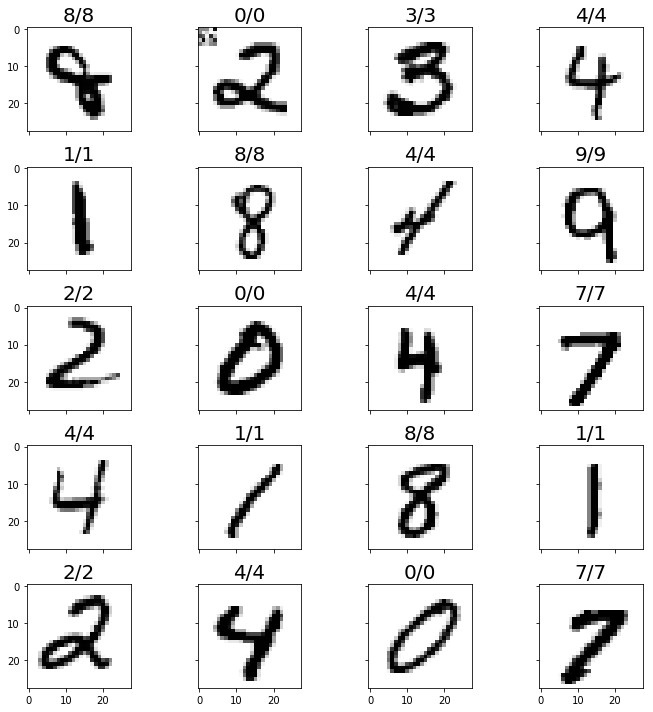

In [38]:
def label_getter(l, i):
    return '{}/{}'.format(str(l[0][i]), str(l[1][i]))

plot.grid(dataset_poisoned.x_test,
          [dataset_poisoned.y_test_cat, y_test_pred],
          label_getter,
          fraction=0.002)